In [1]:
## Notebook env: brian_script_env (R kernel)

In [3]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)

path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_original_tnbc/'
path2 = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_tnbc/'

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [12]:
## load patient metadata
meta = read.csv('/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




[1] FALSE

png 
  2

png 
  2

[1] 72.4063

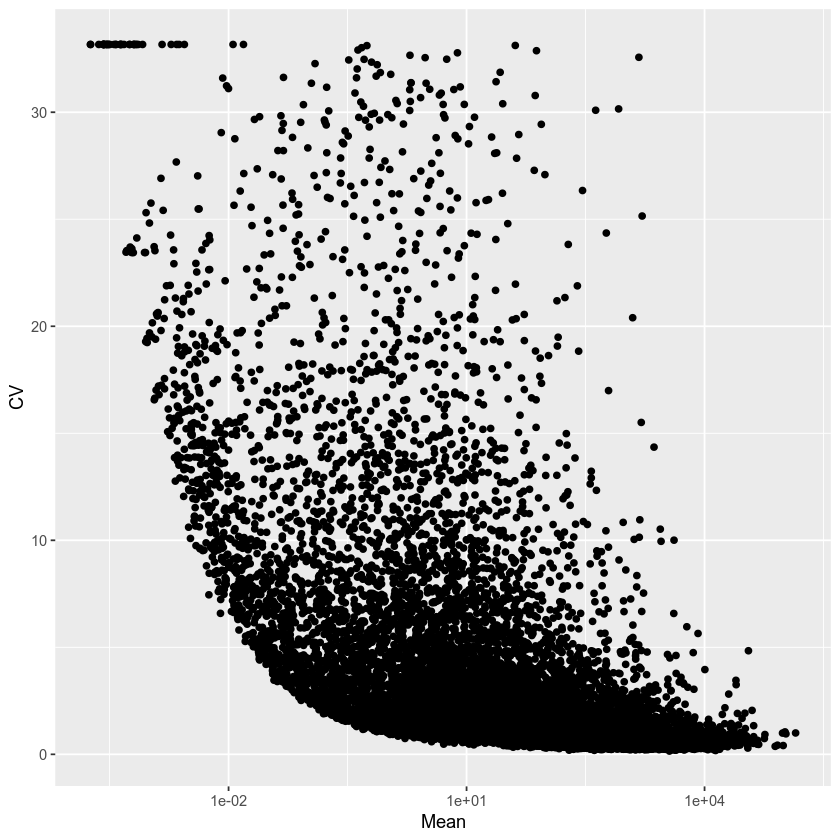

In [3]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_tnbc$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 578

[1] TRUE

[1] TRUE

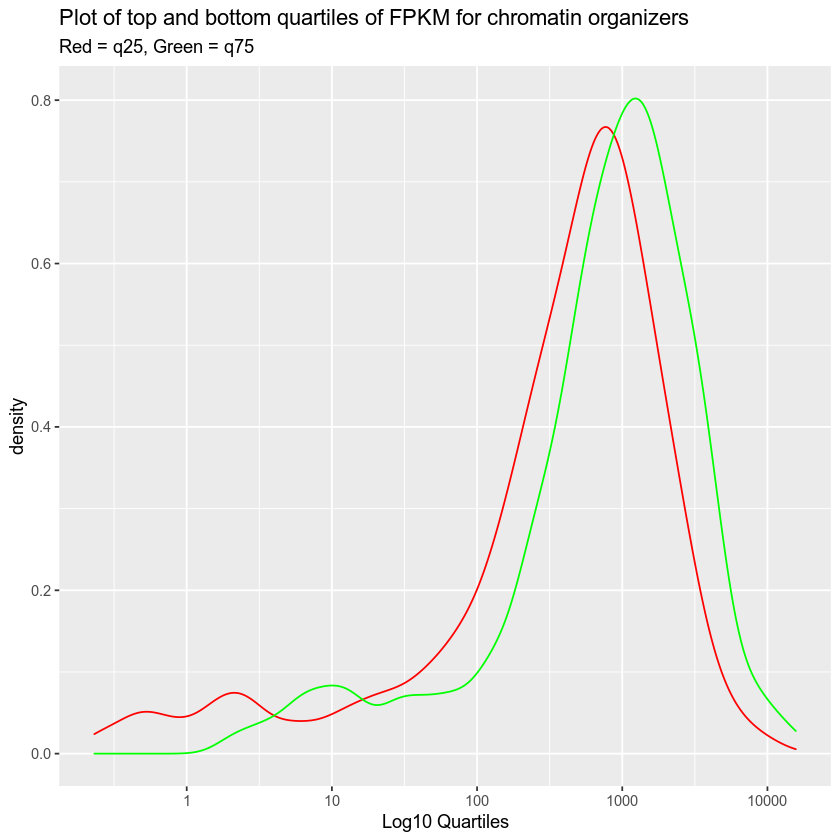

In [4]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.25), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.75), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [5]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path, 'gped_clean_df_CV_ratio_q25_q75.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALJ.01" "TCGA.5T.A9QA.01" ...
 $ : chr [1:275] "TCGA.A1.A0SB.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" ...
List of 560
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.5L.AAT1.01" "TCGA.A1.A0SD.01" "TCGA.A1.A0SG.01" "TCGA.A2.A04W.01" ...
  ..$ : chr [1:275] "TCGA.5T.A9QA.01" "TCGA.A1.A0SI.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AALJ.01" "TCGA.A1.A0SB.01" "TCGA.A1.A0SE.01" "TCGA.A1.A0SH.01" ...
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.5L.AAT1.01" "TCGA.5T.A9QA.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SF.01" ...
  ..$ : chr [1:275] "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" "TCGA.A2.A04T.01" "TCGA.A2.A0CM.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
 

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	20251 obs. of  277 variables:
  ..$ Hugo_Symbol    : chr [1:20251] "LOC100130426" "UBE2Q2P3" "UBE2Q2P3" "LOC149767" ...
  ..$ Entrez_Gene_Id : int [1:20251] 100130426 100133144 100134869 10357 10431 155060 26823 280660 317712 340602 ...
  ..$ TCGA.5L.AAT1.01: num [1:20251] 0 0 10.6 116 1108.4 ...
  ..$ TCGA.A1.A0SD.01: num [1:20251] 0 9.52 11.32 60.26 977.92 ...
  ..$ TCGA.A1.A0SG.01: num [1:20251] 0 6.06 4.38 68.58 1072.81 ...
  ..$ TCGA.A2.A04W.01: num [1:20251] 0 1.31 4.64 101.33 1759.83 ...
  ..$ TCGA.A2.A04X.01: num [1:20251] 0 1.48 2.85 70.51 1451.2 ...
  ..$ TCGA.A2.A0CK.01: num [1:20251] 0 0.998 2.638 113.665 795.556 ...
  ..$ TCGA.A2.A0CL.01: num [1:20251] 0 10.77 7.76 91.26 738.32 ...
  ..$ TCGA.A2.A0CO.01: num [1:20251] 0 9.86 6.43 97.52 572.74 ...
  ..$ TCGA.A2.A0CP.01: num [1:20251] 0 10.23 4.51 96.51 1263.4 ...
  ..$ TCGA.A2.A0CQ.01: num [1:20251] 0 7.47 5.75 86.6 1406.34 ...
  ..$ TCGA.A2.A0CR.01: num [1:20251] 0

[1] TRUE

[1] FALSE

[1]  1.02410255  0.90368186  1.05170307  0.92982322  0.97503771  0.96496721
    [7]  0.87765489  0.79201798         NaN  0.40808203  0.92418063  1.01058422
   [13]  1.63817605  1.04387018         NaN         NaN  1.57032213  1.17976221
   [19]  0.83404989  0.70381333  0.60440167  1.00260821         NaN  0.70851314
   [25]  1.63820149  2.69668113  0.71282094  0.75965029  2.28768288  3.57246060
   [31]  1.39956772  0.96830789  1.59634539  1.16838328  1.08393751  0.96146119
   [37]  0.83081283  0.90177706  1.68842131  0.63604146  0.82597862  0.63690488
   [43]  0.89178215  4.92758393  0.72988116  0.84860825  0.94558615  0.83447468
   [49]  0.38455014  1.10017834  0.65636351  1.08703453  0.94844729  1.21101926
   [55]  0.85331850  0.76830727  1.02870191  0.87039916  1.17663253  0.93133440
   [61]  1.05140483  1.32644302  0.90873153  1.05965117  1.03303941  1.19647282
   [67]  0.83467957  1.08147135  1.05865447  0.94029523  0.93770480  1.17314814
   [73]  0.85781841  1.10026783  1.12686122  1.45022273  0.96156672  0.90607744
   [79]  0.90765984  0.90929501  1.07656140  1.05796234  0.80372874  0.70290287
   [85]  1.46054362  1.11244291  3.38402589  0.74079758  0.99445372  0.96639569
   [91]  1.13430960  1.16032807  1.05676996  0.85311689  0.61362506  0.77956678
   [97]  1.08669170  0.98663272  0.82067170  0.82053684  1.25403928  0.84418308
  [103]  0.90841695  1.05082864  0.40217073  2.29387109  2.99077143  0.94134371
  [109]  0.92237106  1.10960358  1.05047964  1.46683858  0.96979963  0.91570829
  [115]  0.71670063  0.77988127  0.96703375  0.69853772  1.50095837  0.90459758
  [121]  0.87506295  0.91906290  0.78661963  1.11598187  0.95821564  0.93973420
  [127]  0.80782101  0.84428774  0.94715162  0.82605767  1.22108960  0.85400990
  [133]  0.92708099  1.22542074  3.34198614  1.09438019  1.10229517  0.72661347
  [139]  0.87042017  0.75662654  0.91763558  0.70032485  1.11595262  0.75055884
  [145]  0.84452360  1.01741965  0.93478450  0.63769026  0.81122999  0.83007967
  [151]  0.93068868  0.70602560  1.03633458  0.98573536  0.82848881  0.95356774
  [157]  1.02437837  0.93630181  0.93406477  0.82455453  0.88385955  0.97701037
  [163]  1.26292015  1.57553955  1.30578026  0.78189712  0.55825835  1.15952614
  [169]  1.09310969  1.10071906  1.07339855  0.98796063  0.49314377  1.28583183
  [175]  1.21215358  1.15226487  0.38904125  1.01183503  0.80975769  0.76835268
  [181]  0.94058997  1.16055380  1.01353084  1.29419577  1.88462501  1.06086975
  [187]  0.83708346  0.84996755  0.94108330  0.37622747  1.16438334  1.00160537
  [193]  1.03506599  0.75278362  0.88750090  0.82966024  1.20141332  0.84750767
  [199]  0.94309020  0.27855284  0.88810151  0.74817830  0.63363373  1.56739687
  [205]  1.00215257  0.93858642  0.93735302  1.16310140  0.54473515  0.93591106
  [211]  0.90163821  0.76755289  0.88267882  0.91846127  1.28138991  0.74531082
  [217]  1.63899755  0.42180299  0.79149442  2.41266010  1.04985314  0.97101515
  [223]  1.00209795  0.96901928  0.87584616  0.98383519  3.06197472  1.08924893
  [229]  0.70097754  1.11262980  3.84599508  0.90221481  0.73432307  0.96070112
  [235]  0.55318570  0.91187572  1.30081777  1.23749303  1.28808549  0.98352959
  [241]  3.42784891  1.47518923  0.92591366  0.90681819  0.89271301  1.05206408
  [247]  0.91839455  1.30400326  1.11577194  1.00482612  0.26602877  1.00612936
  [253]  0.91125825  1.44186645  0.98746907  1.01086404  0.80262316  0.92448521
  [259]  0.97214285  0.86916070  0.91279316  0.68838866  2.54363092  1.13593440
  [265]  0.97196615  0.92214031  0.22396466  0.91873737  0.76852364  1.59468220
  [271]  1.19472385  1.01553654  0.82345848  0.67412180  0.69540259  0.86281558
  [277]  0.81890078  0.78491287  0.86354369  0.82821684  1.24412812  1.12600830
  [283]  1.35425510  0.84005087  0.60399371  0.81836539  1.10171960  1.09645434
  [289]  0.86604210  1.18937640  1.22387753  0.62946306  1.11567759  0.86864225
  [295]  0.93085376  0.90274622  0.71493480  1.16241418  1.17175415  1.43030065
  [3

[1] TRUE

[1] TRUE

In [6]:
#compare to the original set of random names; last entries should all be TRUE
names_CV_clean %in% random_names 

length(grouped_dataframes_list_with_CV_ratio) == length(grouped_dataframes_list_with_CV_ratio_cleaned) #TRUE

#TEMPORARY: to not break further code, move forward with CV ratio object

grouped_dataframes_list_with_CV_ratio_cleaned <- grouped_dataframes_list_with_CV_ratio

#' 
#' ### Using z-score thresholding approach to determine significant genes
#' 
#' Let's now try to use the *grouped_dataframes_list_with_CV_ratios_cleaned* object that was created previously and do a gene-by-gene analysis followed by z-score thresholding at the factor level (very last step).
#' 
#' What I will do now: for each matched row (corresponds to a gene) in q25, q75 dataframes: create a two-entry dataframe with first column being all of the observations, and the second being the grouping variable (q25, q75). Then, run the asymptotic test on this dataframe. Take the p-value and whether or not the CV went down from q25 to q75. Record these two entries.
#' 
## ---- z-score thresholding-----------------------------------------------------
#As a check: first check that the grouped dataframes list input has the same gene name in #every row, and in the right position, for both the q25 and q75 dataframes. I.e. check #that the gene names (first column) are identical for both q25, q75 dataframes.

order_checker <- function (df_list, gene_column = 1, q25_entry = 3, q75_entry = 4) {
#This checks if the order and IDs of the first column in the specified dataframes nested #within the df_list object (a list of dfs) match exactly, returning a logical value.
#This is then iterated over the entire df_list (in the two objects created below, 'list'
#refers EACH INDIVIDUAL ENTRY in the full dataframe list.)
names_q25_list <- lapply(df_list, function (single_list_from_df_list) {
                         return (single_list_from_df_list[[q25_entry]][,gene_column]) } )

#get lists of gene IDs for all q25 dataframes 
names_q75_list <- lapply(df_list, function (single_list_from_df_list) {
                         return (single_list_from_df_list[[q75_entry]][,gene_column]) } )
return (identical(names_q25_list, names_q75_list))
}

order_checker(grouped_dataframes_list_with_CV_ratio_cleaned) #TRUE

#Now: define two functions that will carry out the logic of CV testing at the level of a #single entry (i.e. list of dataframes) within the master list of dataframes. The first #function calls the second, which actually carries out the asymp test.

indices_to_omit = -1:-4 #the gene name, entrez ID, CV, CV ratio

asymp_test_applier <- function (list_of_df, name_entry = 1, random = 2, q25_entry = 3, 
                                q75_entry = 4, f = asymp_test_q25_q75, 
                                omitted_indices = indices_to_omit) {
    chromatin_organizer_name <- list_of_df[[name_entry]]
    random_designation = list_of_df[[random]]
    list_of_p_vals <- lapply(1:length(rownames(list_of_df[[q25_entry]])), f, q25_entry, 
                             q75_entry, list_of_df, omitted_indices)
    #the p-val list (returns list of 2-entry lists with name in first entry, p-val in second)
    df_of_p_vals <- do.call(rbind.data.frame, list_of_p_vals)
    #unlist into a dataframe
    colnames(df_of_p_vals) <- c('Gene', 'asymptotic_test_p-val')
    #assign appropriate column names
    return (list(chromatin_organizer_name, random_designation, df_of_p_vals))
    #return a 2-entry list: first is character, second is df
}

asymp_test_q25_q75 <- function (row, q25_entry, q75_entry, list_of_df, 
                                omitted_indices) { 
  #getting the gene name, which is in the specified name entry column 
  #(generally first column)
  names <- c('Expression', 'Quartile')
  gene_name <- list_of_df[[q25_entry]][row, 1]
  #get rows of interest
  q25_list <- t(list_of_df[[q25_entry]][row, omitted_indices]) 
  q75_list <- t(list_of_df[[q75_entry]][row, omitted_indices]) 
  #Need to take transpose to get this row into column format; corresponds to only numeric indices
  q25_data <- data.frame(cbind(q25_list, 'Bottom'), stringsAsFactors = FALSE)
  q75_data <- data.frame(cbind(q75_list, 'Top'), stringsAsFactors = FALSE)
  #Make dataframes that correspond to two columns: the expression levels and a grouping variable
  colnames(q25_data) <- names
  colnames(q75_data) <- names
  #Assign column names
  df_to_test <- rbind(q25_data, q75_data)
  #Make a master df that I run the asymptotic test on: first arg of asymptotic_test is the numeric
  #column, and the second arg is the grouping variable of choice (here: bottom vs top)
  test <- asymptotic_test (as.numeric(df_to_test[,1]), 
                           df_to_test[,2])
  return (list(gene_name, test$p_value))
}

#The call to make a list of agglomerated p-values: should have same as the number of chromatin modifiers, 
#and each entry in the list should be a two entry list, with the first entry being the factor of interest, 
#and the second entry in the list being another list (should have 20440 entries).  

#!!!!SLOW!!!!!! call; 23hrs using pblapply
df_of_p_vals <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned,
                         asymp_test_applier, cl = 4)

save(df_of_p_vals, file = paste0(path, 'df_p_vals_q25_75.RData'))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[517] FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[529]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[541]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[553]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

[1] TRUE

[1] TRUE

In [7]:
length(df_of_p_vals) #562 for FPKM set.seed(42) run

#First: some QC to make sure that the structures of the two data objects are equivalent

#check that the factor names all match between CV dataframe list, p_vals list
names_CV <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                   function (list) list[[1]])

names_p_vals <- lapply(df_of_p_vals, function (list) list[[1]])

identical (names_CV, names_p_vals) #TRUE


#Optional code: 

#load("~/Downloads/df_p_vals_q25_q75.RData")
#df_of_p_vals

#'  
#' ### Qvals for all genes in each grouping, and z-score for each factor
#' 
#' Now: I need to append the previously calculated CV columns for all genes in the
#' q25 and q75 dataframes in the grouped_dataframes_list_with_CV_ratio object to this
#' list of dataframes with p vals. Why? First, I would like to get qvalues for the corresponding p-vals at an fdr of .05. I would then like to flag which qvals are significant after this adjustment.
#' 
#' I then need CVs because I need to then get the genes that show LOWER CV in bottom quartile compared to top => higher expression of chromatin factor means higher CV. 
#' 
## ---- q value calcs and z-score calculations-----------------------------------
#Appending the CV columns from previously defined 'grouped_dataframes_list_with_CV' object.
#The bottom two statements return a list of the CV q25 column and q75 column respectively

CV_q25_cols <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                      function (list) {list[[3]]$CV})

CV_q75_cols <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                      function (list) {list[[4]]$CV})

#Check that the length of each list is the same

length(CV_q25_cols) == length(CV_q75_cols) #TRUE

length(grouped_dataframes_list_with_CV_ratio_cleaned)

#Apply a function that will append adjusted qvals, the CVs of the q25 and q75 columns 
#(we checked that the name ordering was the same previously) if a logical flag is given,
#etc to the list of p value dataframes object from earlier

append_cols_p_q <- function (index, data, df_entry = 3, p_col = 2, 
                             col1 = CV_q25_cols, col2 = CV_q75_cols, 
                             CV = TRUE, pi0 = NULL) 
  #index refers to the factor index of interest, df_entry is the list entry in the 
  #pval df corresponding to the data, p_col is the column with asymptotic p vals,
  #args is the columns wanted to be appended
  {
  data_of_interest <- data[[index]][[df_entry]][[p_col]]
  qval_of_interest <-  qvalue (data_of_interest, 
                                fdr.level = .05, pi0 = pi0)
  #Adjust the p_vals in the current df
  col_of_sign_q <- qval_of_interest$qvalues < .05
  #Flag the qvals (genes) that are significant at alpha = .05
  data[[index]][[df_entry]]$adj_q_val <- qval_of_interest$qvalues
  data[[index]][[df_entry]]$sign_alpha_.05 <- col_of_sign_q
  #Add corresponding columns that mark significant q-vals 
  if (CV) {
  up_or_down <- (col1[[index]]/col2[[index]]) < 1
  #first argument should be CV_q25 column, second is CV_q75
  #If TRUE, denotes a gene that had lower CV in bottom quartile
  #of expressers for chromatin factor compared to top quartile 
  #expressers. Means higher expression has higher CV.
  data[[index]][[df_entry]]$CV_q25 <- col1[[index]]
  data[[index]][[df_entry]]$CV_q75 <- col2[[index]]
  data[[index]][[df_entry]]$CV_upregulation <- up_or_down
  }
  return (data[[index]]) 
}

appended_p_val_df <- pblapply(seq_len(length(df_of_p_vals)), append_cols_p_q,
                          df_of_p_vals)


#Test that the q25 dataframe CV column for gene at index 2 in the grouped dataframes 
#list object matches that of the corresponding CV column in the new appended list of 
#p val df object

length(appended_p_val_df) #562

length(colnames(appended_p_val_df[[2]][[3]])) == 7 #TRUE

identical (grouped_dataframes_list_with_CV_ratio_cleaned[[2]][[3]]$CV, 
           appended_p_val_df[[2]][[3]]$CV_q25)

#TRUE: test that the appended CV column matches the column from original grouped dataframe with CV

grouped_dataframes_list_with_CV_ratio_cleaned[[2]][[1]] == appended_p_val_df[[2]][[1]] 

#TRUE, test name match

#Subsetting the appended_p_val_df: focusing on factors that are significant, call table on
#genes that ARE significant, and then count the 'CV_upregulation' column to find ones that
#are upregulating CV upon higher expression. Should return list with two entries in every
#list entry, first = name, second = table.

#As a note: this next object drops all the information about qvals on a gene by gene
#basis, etc., and only retains information now at the factor level

count_sig_qvals <- function (index, data, df_entry = 3, CV_col = 7, CV = TRUE) {
   df_of_interest <- data[[index]][[df_entry]]
   #reassignment for easier reference later
   new_frame <- df_of_interest[df_of_interest$sign_alpha_.05 == TRUE, ]
   #Now get the table of up/down within subset of sign. genes
   if (CV) {
   count_table <- table(new_frame[CV_col])
                 #Return two-entry list, with second entry being table
                  return (list(data[[index]][[1]], 
                          data[[index]][[2]],
                          count_table))
   } else {
   number_sig_genes <- length(rownames(new_frame))
   return (list(data[[index]][[1]], 
                          data[[index]][[2]],
                          number_sig_genes))
   }
}

list_of_tables_up_down <- pblapply(seq_len(length(appended_p_val_df)), count_sig_qvals, 
                data = appended_p_val_df)

#Get the random and grouped means and sds, using the random_designation tag. Gets the 
#summary statistics for the random grouping, _GROUPED_BY_ 'cv lower' or 'cv higher' tag 

random_false <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "Y") {list[[3]][[1]]} }))

random_true <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "Y") {list[[3]][[2]]} }))

grouped_false <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "N") {list[[3]][[1]]} }))

grouped_true <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "N") {list[[3]][[2]]} }))

random_false_sd <- sd(random_false)
random_false_mean <- mean(random_false)
random_true_sd <- sd(random_true)
random_true_mean <- mean(random_true)

save(appended_p_val_df, file = paste0(path, 'df_appended_q_vals_q25_75.RData'))

[1] 560

[1] TRUE

[1] TRUE

[1] 560

[1] 560

[1] TRUE

[1] TRUE

[1] TRUE

Chromatin factor name,variable,value
<fct>,<fct>,<dbl>
ACTL6A,Higher_expression_meant_lower_CV,-0.7438468
ACTR5,Higher_expression_meant_lower_CV,-0.9097599
ACTR6,Higher_expression_meant_lower_CV,-0.9263512
ACTR8,Higher_expression_meant_lower_CV,0.3200388
AEBP2,Higher_expression_meant_lower_CV,-0.5547059
AKAP8L,Higher_expression_meant_lower_CV,-0.9896534
AKAP8,Higher_expression_meant_lower_CV,-0.7349130
ANP32B,Higher_expression_meant_lower_CV,-0.9426872
ANP32E,Higher_expression_meant_lower_CV,-0.7862185


png 
  2

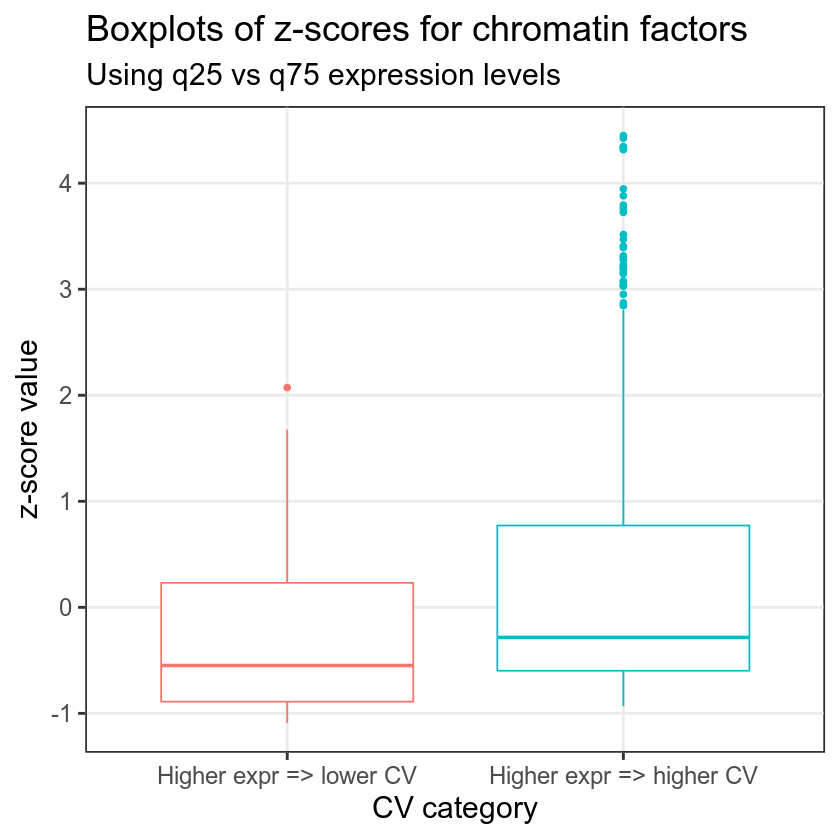

In [8]:
#Rest of the analysis

#First isolate the grouped factors by using the random designation

#Returns a 'logical list'
cond <- lapply(list_of_tables_up_down, function (list) list[[2]] == "N")

#Subsetting vector by atomic mask, unlisting it to place into vector format
grouped_list <- list_of_tables_up_down[unlist(cond)]

#Returns a new list with converted z-scores: for each entry in the grouped list, subtracts
#out the corresponding random mean scalar, and divides by the corresponding random sd
grouped_list_z <- lapply(grouped_list, function (list) {
  z_score_false <- (list[[3]][[1]] - random_false_mean)/random_false_sd
  z_score_true <- (list[[3]][[2]] - random_true_mean)/random_true_sd
  #reassign the list, and return it 
  list[[3]][[1]] = z_score_false
  list[[3]][[2]] = z_score_true
  return (list(list[[1]], list[[3]]))
})

#Make a dataframe out of this 'z-list': extract relevant elements from this new list &
#return a dataframe in wide format
grouped_z_name <- lapply(grouped_list_z, function (list) {
  list[[1]]
})

grouped_z_false <- lapply(grouped_list_z, function (list) {
  list[[2]][[1]]
})

grouped_z_true <- lapply(grouped_list_z, function (list) {
  list[[2]][[2]]
})

#The data.frame call: make a 3-col dataframe with name, numeric z-score for cv-low cond,
#and cv-hi condition
z_df <- data.frame(unlist(grouped_z_name), unlist(grouped_z_false),
                   unlist(grouped_z_true))

colnames(z_df) <- c("Chromatin factor name", "Higher_expression_meant_lower_CV",
                    "Higher_expression_meant_higher_CV")

#Return a long-format dataframe, keeping the first row as id variable (chromatin factor)
z_melt <- melt(z_df, id.vars = "Chromatin factor name")

z_melt

#Plotting out the z-scores for both conditions: (note that multiple theme calls means
#that last one can take precedence (?))
z_plot_unlabeled <- ggplot(z_melt, mapping = aes(x = variable, y = value)) + 
  geom_boxplot(aes(color = variable)) +
labs (title = 'Boxplots of z-scores for chromatin factors',
      subtitle = 'Using q25 vs q75 expression levels',
      x = 'CV category',
      y = "z-score value") + 
scale_x_discrete(labels = c("Higher expr => lower CV", "Higher expr => higher CV")) + 
theme_bw(18) +
theme(legend.position = "none") + 
theme(panel.background = element_rect(colour = "black"), panel.grid.minor = element_blank())

pdf(paste0(path, 'q25_q75_filtered_genes_CV_z_scores.pdf'), height = 12, width = 12)
z_plot_unlabeled
dev.off()

z_plot_unlabeled


[1] 7

[1] 28

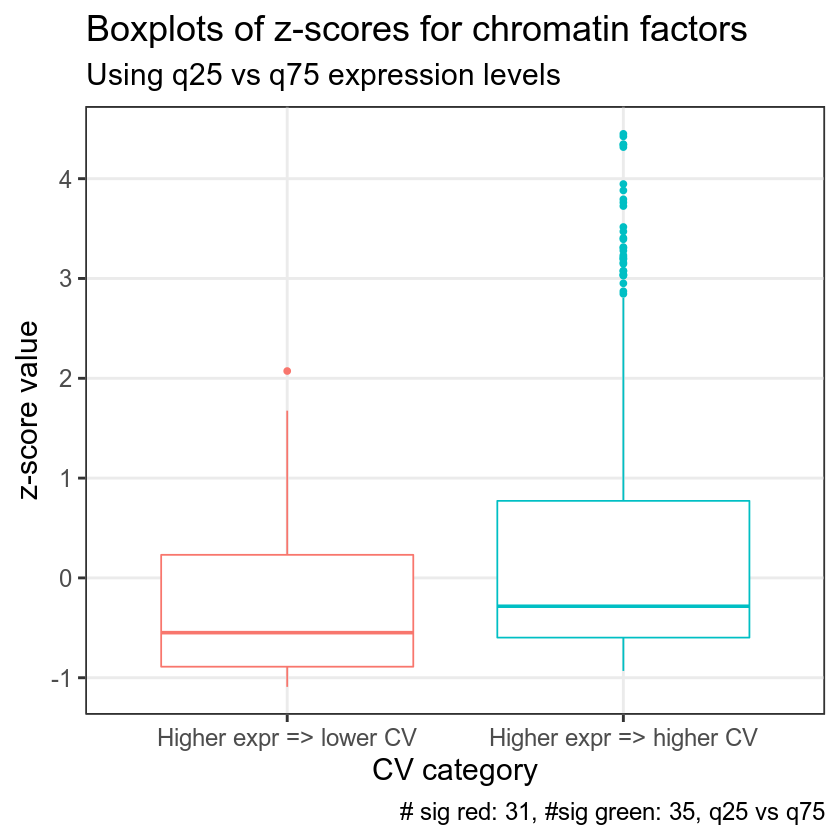

In [9]:
#Saving data, thresholding it
anti_threshold <- 1.5
corr_threshold <- 3
write.csv(z_df, paste0(path, 'z_df_q25_q75.txt'))

z_df_clean <- z_df[(z_df[,2] >= anti_threshold | z_df[,3] >= corr_threshold),]


z_df_lo <- z_df_clean[(z_df_clean[,2] >= anti_threshold), c(1, 2)]
z_df_up <- z_df_clean[(z_df_clean[,3] >= corr_threshold), c(1, 3)]

length(rownames(z_df_lo))
length(rownames(z_df_up))

z_plot_unlabeled + labs (caption = "# sig red: 31, #sig green: 35, q25 vs q75")

write.csv(z_df_lo, paste0(path, 'z_df_lowered_q25.txt'))
write.csv(z_df_up, paste0(path, 'z_df_up_q75.txt'))

In [10]:
save.image(file = paste0(path, 'end_save.RData'))

In [11]:
#' ###Comparing magnitude of CV influence from q25/q75 analysis to q10/q90
#' 
#' Now, let's compare the analysis from using the bottom and top quartile to calculate CV,
#' to using the bottom and top 10/90%, respectively. Why? We should see a dosage dependency in
#' doing so. This means that there isn't any strict 'perfect expression level' that any factor
#' has to be at in order to influence CV. 
#' 
#' Should have two graphs: 
#' 
#' First, should have a venn diagram showing overlap between the two analyses: is the analysis using the q25/q75 condition a subset of using the q10/q90? 
#' 
#' The other: is a boxplot of the z-score distribution between q25/q75 and 
#' q10/q90; the z-scores in the q10/q90 comparison should all be markedly higher. Do this only
#' between the shared genes.
#' 
## ---- checking q25/q75 to q10/q90----------------------------------------------
#Data loading 
z_df_up_q75 <- read.csv(paste0(path, 'z_df_up_q75.txt'), stringsAsFactors=FALSE)

z_df_up_q90 <- read.csv(paste0(path2, 'z_df_up_q90.txt'), stringsAsFactors=FALSE)

#Make an elementary venn diagram from using the two names
venn_list_names_input <- list("Sig factors, from using q25 vs q75" =
                                z_df_up_q75$Chromatin.factor.name,
                              "Sig factors, from using q10 vs q90" =
                                z_df_up_q90$Chromatin.factor.name)


pdf(paste0(path, 'filtered_genes_venn.pdf'), height = 12, width = 12)
venn(venn_list_names_input, intersections = TRUE)
dev.off()

#look at intersected factors, plot their corresponding z-score distribution

intersected_names <- 
intersect (z_df_up_q75$Chromatin.factor.name, z_df_up_q90$Chromatin.factor.name)

z_df_up_q90_intersected <- 
z_df_up_q90[z_df_up_q90$Chromatin.factor.name %in% intersected_names,]

z_df_up_q90_intersected$quartile <- "From analysis using bottom 10% vs top 90%"

z_df_up_q75_intersected <- 
z_df_up_q75[z_df_up_q75$Chromatin.factor.name %in% intersected_names,]

z_df_up_q75_intersected$quartile <- "From analysis using bottom quartile vs top quartile"

z_comparison_melt <- rbind(z_df_up_q75_intersected, z_df_up_q90_intersected)


#Plotting out the z-scores for both conditions: 
z_plot_comparison <- ggplot(z_comparison_melt, 
mapping = aes(x = quartile, y = Higher_expression_meant_higher_CV)) + 
geom_boxplot() +
labs (title = 'Boxplots of z-scores for chromatin factors', 
      subtitle = 'Comparing factors resulting from using q25 vs q75, and q10 vs q90',
      x = 'Group',
      y = "z-score value") + 
  theme_bw(18) +
theme (legend.position = "none") +
  theme(panel.background = element_rect(colour = "black"), panel.grid.minor = element_blank())

pdf(paste0(path, 'z_plot_comparison_filtered_genes.pdf'), height = 12, width = 12)
z_plot_comparison
dev.off()

png 
  2

png 
  2

[1] "ASF1B"   "AURKA"   "AURKB"   "MRGBP"   "MIS18A"  "CCNA2"   "CCNB1"  
 [8] "CDC45"   "CDK1"    "CENPA"   "CENPH"   "CENPM"   "CENPN"   "CENPW"  
[15] "CHEK1"   "ENY2"    "EZH2"    "H2AFZ"   "HJURP"   "HMGA1"   "HMGB3"  
[22] "JMJD6"   "NUDT5"   "OIP5"    "RCCD1"   "NELFE"   "SUPV3L1" "VRK1"

[1] "ABCF3"           "ACVR2A"          "ARHGAP20"        "DKFZp434A1010"  
 [5] "ATP6V1B2"        "MAATS1"          "SIMC1"           "C9ORF84"        
 [9] "CSTF2"           "ECT2"            "EFNA5"           "HDHD3"          
[13] "HIGD1B"          "KCNS1"           "KLF11"           "KLRC3"          
[17] "LILRA1"          "LRRC45"          "LSM5"            "MSLN"           
[21] "NANOS1"          "FBXL19-AS1"      "NTM"             "LOC402713"      
[25] "MXRA2~withdrawn" "DKFZP566G2246_2" "PLSCR4"          "PTPRN2"         
[29] "ZBED9"           "SCN3A"           "SLC3A1"          "SOD1"           
[33] "SS18"            "STAT6"           "TIMP1"           "TMEM74"         
[37] "TUBA3C"          "UBAC2"           "ZSCAN20"

[1] FALSE

[1] TRUE

png 
  2

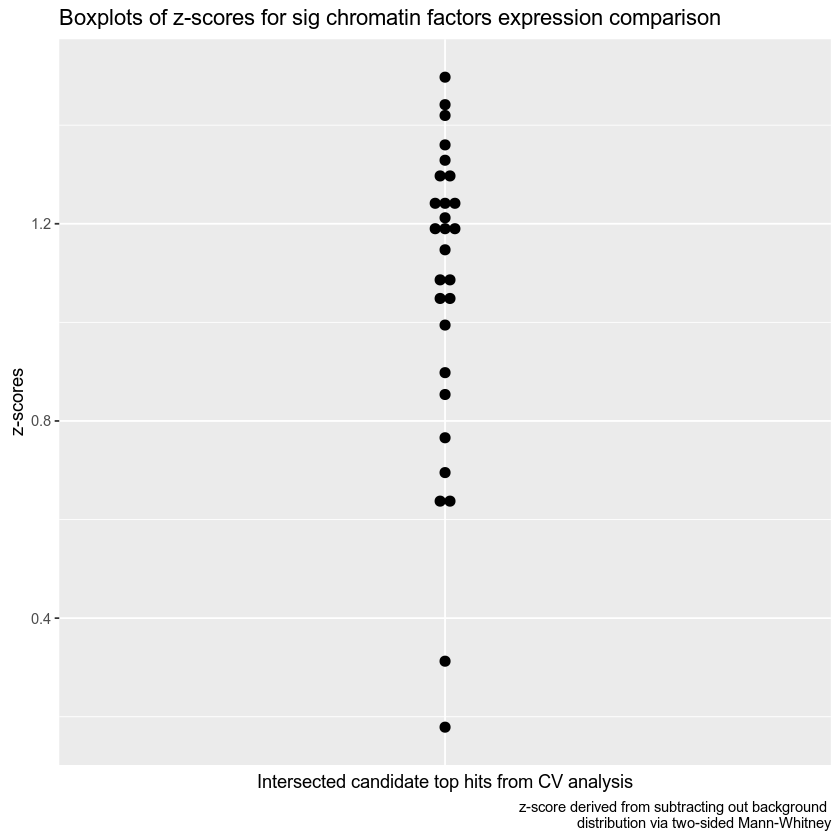

In [12]:
#' ###Expression validation for the top candidates identified previously
#' 
#' Additionally, look at **expression** of these factors: does it differ between the two groupings (check q10/q90 first, as this arguably is a more extreme version of the q25/q75 grouping)? If so, then this could be influencing the CV of the genes in question: the two aren't as independent as it seems. 
#' 
#' Run a Mann-Whitney test for expression, two-sided between the two groups. Basically, re-run the analysis but instead of using the asymptotic test, use the MW test for difference of populations.
## ------------------------------------------------------------------------------
#Look at the previously defined intersected names vector, and get a corresponding vector
#using the random groupings genes

intersected_names

names_of_random <- unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                          function (list) {if (list[[2]] == "Y") {
                            return (list [[1]])
                          }}
                  ))

names_of_random

#Test that the correct names were pulled out 
test_names <- unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned[509:546],
                            function (list) {list[[1]]}))

identical(test_names, names_of_random) #TRUE

#Now get the full corresponding data from the full dataset list

full_names <- c(intersected_names, names_of_random)

inter_logical_cond <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) { list[[1]] %in% full_names})

inter_list <- grouped_dataframes_list_with_CV_ratio_cleaned[unlist(inter_logical_cond)]

length(inter_list) == length(full_names) #TRUE

#Let's now repeat the entire analysis for this smaller intersected list subset. Let's
#apply a wilcoxon ranked sum test to the smaller list, instead of the asymptotic test for #CV used previously. Same workflow applies.

#Now, let's define a function that will compute the wilcoxon ranked sign test for 
#intersected_list that we just subsetted. 

wilcox_q10_q90 <- function (row, q25_entry, q75_entry, list_of_df, 
                                omitted_indices) { 
  #getting the gene name, which is in the specified name entry column 
  #(generally first column)
  gene_name <- list_of_df[[q25_entry]][row, 1]
  #get rows of interest
  q25_list <- t(list_of_df[[q25_entry]][row, omitted_indices]) 
  q75_list <- t(list_of_df[[q75_entry]][row, omitted_indices]) 
  #Need to take transpose to get this row into column format; corresponds to only numeric    indices
  test <- wilcox.test(q25_list, q75_list)
  return (list(gene_name, test$p.value))
}

df_intersect_p_vals <- pblapply(inter_list, asymp_test_applier, f = wilcox_q10_q90)



#Repeat relevant analysis using the previous analytical logic from code chunk called
#'q value calcs and z-score calculations'

#Apply previously written function that will append adjusted qvals, etc to the list of p #value dataframes object from earlier

appended_p_val_df_expression <- pblapply(seq_len(length((df_intersect_p_vals))), 
                                         append_cols_p_q, 
                                         df_intersect_p_vals, CV = FALSE)

#Subsetting the appended_p_val_df_expression dataset: focusing on col_of_sign_q, this is
#the number of genes that are actually significantly different between the two conditions
#that we'd like to compare: the top hit candidates only, + the random groupings we used
#originally. The difference here from the previous analysis using CV is that now there
#is no need to look at genes grouped by CV positive/negative correlation. Just 
#simply count the number of genes that are significantly different between the two 
#expression groupings, for both random and true groups, and then derive z-scores this way

list_genes_expression <-  
  pblapply(seq_len(length(appended_p_val_df_expression)), count_sig_qvals, 
                data = appended_p_val_df_expression, CV = FALSE)

#Get the random and grouped means and sds, using the random_designation tag. 

random_sig_genes <- unlist(lapply(list_genes_expression, function (list) 
  {if (list[[2]] == "Y") {list[[3]]}}))

random_sig_sd <- sd(random_sig_genes)
random_sig_mean <- mean(random_sig_genes)

#Return a 'logical list' of genes that are the top hits
cond <- lapply(list_genes_expression, function (list) list[[2]] == "N")

#Subsetting vector by atomic mask, unlisting it to place into vector format
grouped_list <- list_genes_expression[unlist(cond)]


#Returns a new list with converted z-scores: for each entry in the grouped list, subtracts
#out the random mean scalar, and divides by the random sd
grouped_list_z <- lapply(grouped_list, function (list) {
  z_score <- (list[[3]] - random_sig_mean)/random_sig_sd
  #reassign the list, and return it 
  list[[3]] = z_score
  return (list)
})

#Make a dataframe out of this 'z-list': extract relevant elements from this new list &
#return a dataframe in wide format
grouped_z_name <- lapply(grouped_list_z, function (list) {
  list[[1]]
})

grouped_z_z <- lapply(grouped_list_z, function (list) {
  list[[3]]
})

#The data.frame call: make a 3-col dataframe with name, numeric z-score for cv-low cond,
#and cv-hi condition

z_df <- data.frame(unlist(grouped_z_name), unlist(grouped_z_z), 'Normalized Z-score' )

colnames(z_df) <- c("Chromatin factor name", "Z", 'Factor')

write.csv(z_df, paste0(path, 'z_df_expression_check_q25_q75.txt'))



#Plotting out the z-scores for both conditions: 
z_plot <- ggplot(z_df, mapping = aes(Factor, Z)) + 
  geom_dotplot(binaxis = "y", stackdir = 'center', binwidth = 1/50) +
labs (title = 'Boxplots of z-scores for sig chromatin factors expression comparison',
      caption = 'z-score derived from subtracting out background 
      distribution via two-sided Mann-Whitney',
      y = 'z-scores', 
      x = 'Intersected candidate top hits from CV analysis') + 
theme (legend.position = "none",
       axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) 

z_plot

pdf(paste0(path, 'expression_plot_q25_q75.pdf'), width = 10, height = 10)
z_plot
dev.off()

In [13]:
save.image(file = paste0(path, 'end_save2.RData'))

In [1]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(dplyr)
path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_original/'
path2 = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original/'
load(file = paste0(path, 'end_save2.RData'))


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [14]:
z_melt_ordered = z_melt %>% filter(variable == 'Higher_expression_meant_higher_CV') %>% arrange(desc(value))
z_melt_ordered[1:50,]

,Chromatin factor name,variable,value
,<fct>,<fct>,<dbl>
1,H2AFZ,Higher_expression_meant_higher_CV,4.449453
2,CDC45,Higher_expression_meant_higher_CV,4.423715
3,CENPN,Higher_expression_meant_higher_CV,4.345659
4,CENPM,Higher_expression_meant_higher_CV,4.339330
5,AURKB,Higher_expression_meant_higher_CV,4.316125
6,ENY2,Higher_expression_meant_higher_CV,3.946519
7,MRGBP,Higher_expression_meant_higher_CV,3.881964
8,CENPW,Higher_expression_meant_higher_CV,3.793360
9,AURKA,Higher_expression_meant_higher_CV,3.761294


In [15]:
z_melt_ordered[51:100,]

,Chromatin factor name,variable,value
,<fct>,<fct>,<dbl>
51,MCM2,Higher_expression_meant_higher_CV,2.313671
52,SUV39H2,Higher_expression_meant_higher_CV,2.292153
53,BABAM1,Higher_expression_meant_higher_CV,2.280339
54,DPF1,Higher_expression_meant_higher_CV,2.274854
55,HIST1H1B,Higher_expression_meant_higher_CV,2.242366
56,KAT2A,Higher_expression_meant_higher_CV,2.190469
57,MKI67,Higher_expression_meant_higher_CV,2.171905
58,BEND3,Higher_expression_meant_higher_CV,2.145745
59,DNAJC2,Higher_expression_meant_higher_CV,2.130978


In [16]:
write.csv(z_melt_ordered, paste0(path, 'z_melt_ordered_q25_q75.csv'))

In [23]:
library(ggrepel)

In [21]:
## remaking comparison boxplots (z_plot_comparison_filtered_genes_2000DEGs.pdf)

z_df_up_q90$quartile_level = 'q10 vs q90'
z_df_up_q75$quartile_level = 'q25 vs q75'

z_comparison_non_intersected = rbind(z_df_up_q75, z_df_up_q90)

Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


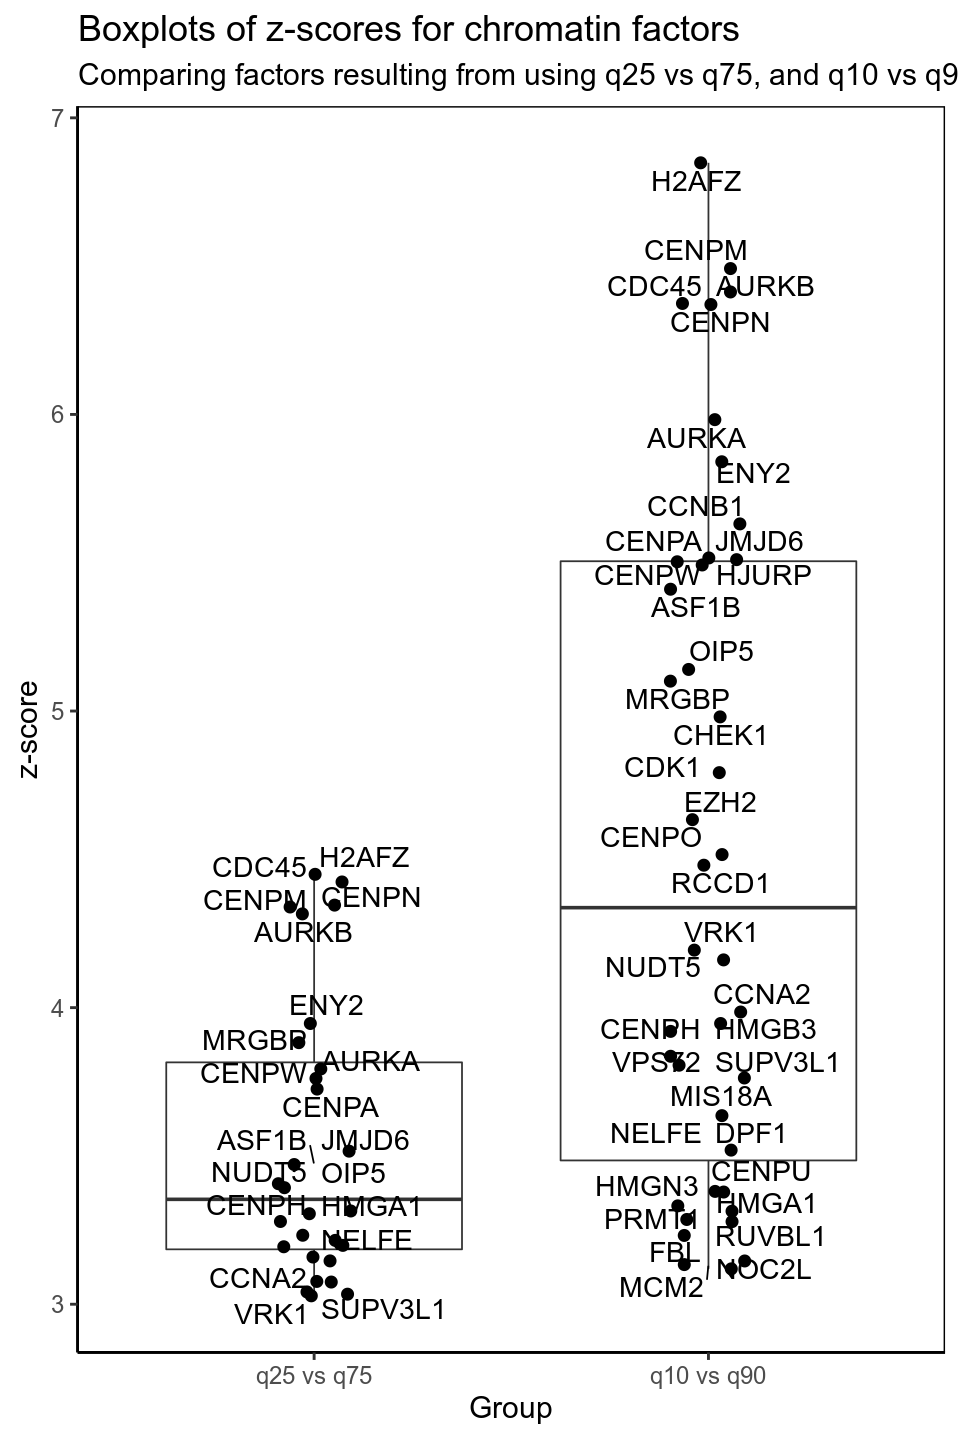

In [26]:
options(repr.plot.width=8, repr.plot.height=12)
z_comparison_non_intersected$quartile_level <- factor(z_comparison_non_intersected$quartile_level, levels = c('q25 vs q75', 'q10 vs q90'))
ggplot(z_comparison_non_intersected, mapping = aes(x = quartile_level, y = Higher_expression_meant_higher_CV)) + 
geom_boxplot() +
geom_jitter(width = 0.1,size = 3) +
  geom_text_repel(data=z_comparison_non_intersected,
            aes(quartile_level,Higher_expression_meant_higher_CV,label=Chromatin.factor.name), size = 6) +
theme_classic(18) + 
labs (title = 'Boxplots of z-scores for chromatin factors', 
        subtitle = 'Comparing factors resulting from using q25 vs q75, and q10 vs q90',
        x = 'Group',
        y = "z-score") + 
theme (legend.position = "none", text=element_text(size=18,  family="Helvetica")) +
theme(panel.background = element_rect(colour = "black"), panel.grid.minor = element_blank())


ggsave(filename = paste0(path, 'z_plot_comparison_labelled.pdf'), width = 8, height = 12)
